In [31]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from PyAstronomy import pyaC
from scipy import stats
import cmocean
import random

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_21.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission_time = np.median(mission_dataset['time'][:])
mission_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 21
    summary: University of Washington - Applied Physics Lab team collected these data using microSWIFT wave buoys at the USACE Field Research Facility as part of the USCRP funded project DUNEX (During Nearshore Events Experiment). The file contains both directly measured and computed quantities from the drifting wave buoys. The collection and processing of these data is explained in the github repository at https://github.com/SASlabgroup/DUNEXMainExp along with examples of how these data can be used.
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim T

In [33]:
# Add in breaking location start based on gamma value for area and average shoreline location
# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
mission_hs = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)
print(mission_hs)

# Compute depth that waves should be breaking in 
mission_break_depth = mission_hs / gamma
print(mission_break_depth)

# Cross Shore Location for start of Breaking
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

mission_xs_gamma_location = np.interp(-mission_break_depth, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission_xs_gamma_location)

# Get shoreline location from waterlevel data
waterlevel_file = '../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
waterlevel_dataset = nc.Dataset(waterlevel_file)
waterlevel = waterlevel_dataset['waterLevel'][:]
waterlevel_time = waterlevel_dataset['time'][:]
mission_waterlevel = np.interp(mission_time, waterlevel_time, waterlevel)
print(mission_waterlevel)

mission_shoreline_location = np.interp(mission_waterlevel, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission_shoreline_location)

2.5459485368362005
7.274138676674859
659.4736618323806
1.2566665526754321
99.47320169748028


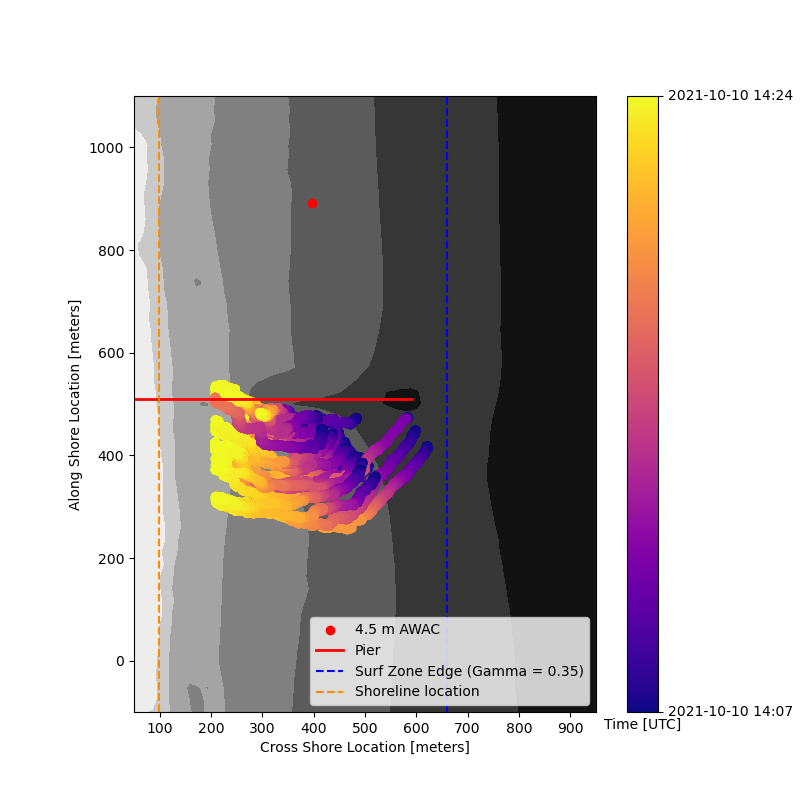

In [34]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
ax = mission_tools.plot_mission_tracks(mission_dataset, bathy_file)
ax.axvline(mission_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax.axvline(mission_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.legend(loc='lower right')

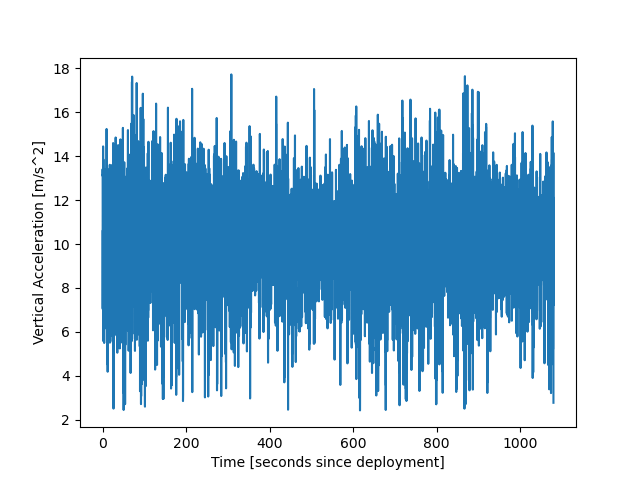

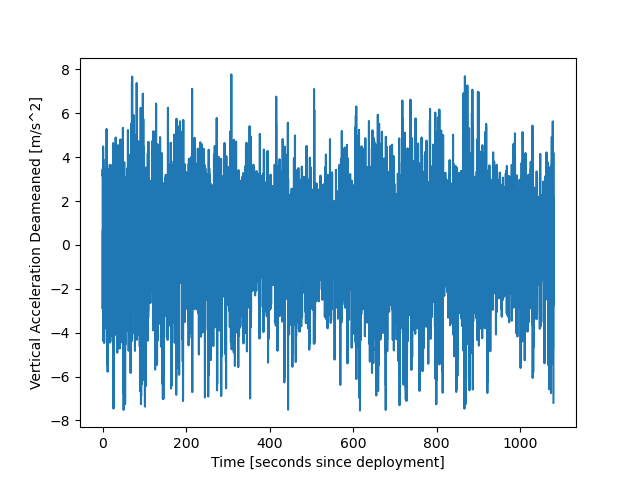

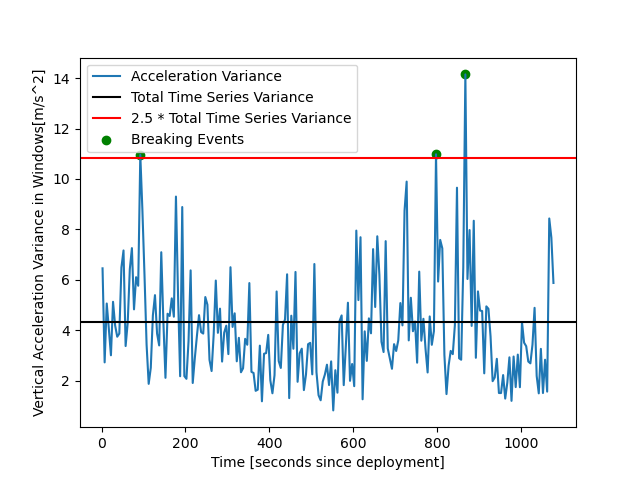

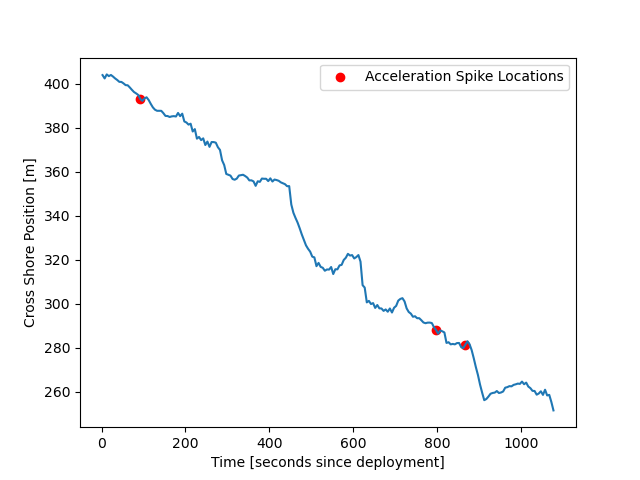

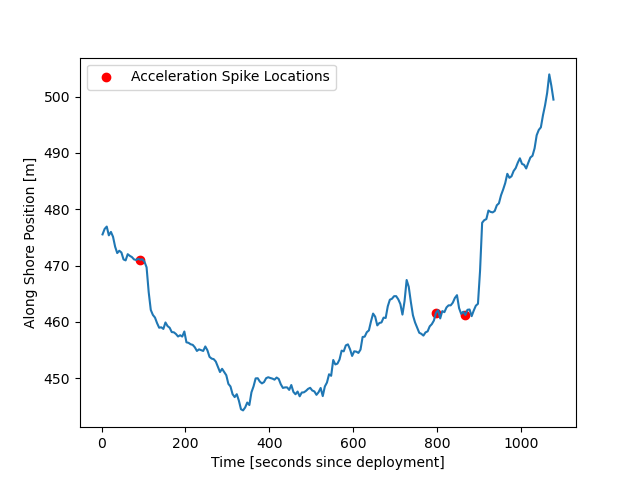

In [35]:
# Plot on Acceleration Time Series
microswift_num = 1
a_z_test = mission_dataset['acceleration_z_body'][microswift_num,:]
xFRF_test = mission_dataset['xFRF'][microswift_num,:]
yFRF_test = mission_dataset['yFRF'][microswift_num,:]
a_z_test_demean = a_z_test - np.nanmean(a_z_test)
time_seconds = np.arange(a_z_test.size)/12

# reshape time series into 5 second windows and compute variance
window_size = 60 # 5 seconds at 12 Hz
a_z_test_reshape = np.reshape(a_z_test_demean[:(a_z_test_demean.size//window_size * window_size)],
                            (a_z_test_demean.size//window_size, window_size))
time_seconds_reshape = np.reshape(time_seconds[:(time_seconds.size//window_size * window_size)],
                                (time_seconds.size//window_size, window_size))
xFRF_reshape = np.reshape(xFRF_test[:(xFRF_test.size//window_size * window_size)],
                                (xFRF_test.size//window_size, window_size))
yFRF_reshape = np.reshape(yFRF_test[:(yFRF_test.size//window_size * window_size)],
                                (yFRF_test.size//window_size, window_size))
a_z_test_window_var = np.nanvar(a_z_test_reshape, axis=1)
time_seconds_window = np.nanmean(time_seconds_reshape, axis=1)
xFRF_window = np.nanmean(xFRF_reshape, axis=1)
yFRF_window = np.nanmean(yFRF_reshape, axis=1)
total_varaince = np.nanvar(a_z_test_demean)

# Find Indices where the variance spikes 
above_thresh_inds = np.where(a_z_test_window_var > 2.5*total_varaince)

fig, ax = plt.subplots()
ax.plot(time_seconds, a_z_test, label='acceleration')
ax.set_xlabel('Time [seconds since deployment]')
ax.set_ylabel('Vertical Acceleration [m/s^2]')
# ax.legend()

fig, ax = plt.subplots()
ax.plot(time_seconds, a_z_test_demean, label='acceleration')
ax.set_xlabel('Time [seconds since deployment]')
ax.set_ylabel('Vertical Acceleration Deameaned [m/s^2]')
# ax.legend()

fig, ax = plt.subplots()
ax.plot(time_seconds_window, a_z_test_window_var, label='Acceleration Variance')
ax.axhline(total_varaince, label='Total Time Series Variance', color='k')
ax.axhline(2.5*total_varaince, label='2.5 * Total Time Series Variance', color='r')
ax.scatter(time_seconds_window[above_thresh_inds],  a_z_test_window_var[above_thresh_inds], color='green', label='Breaking Events')
ax.set_xlabel('Time [seconds since deployment]')
ax.set_ylabel('Vertical Acceleration Variance in Windows[m/s^2]')
ax.legend()

fig, ax = plt.subplots()
ax.plot(time_seconds_window, xFRF_window)
ax.scatter(time_seconds_window[above_thresh_inds], xFRF_window[above_thresh_inds], color='r', label='Acceleration Spike Locations')
ax.set_xlabel('Time [seconds since deployment]')
ax.set_ylabel('Cross Shore Position [m]')
ax.legend()
fig, ax = plt.subplots()
ax.plot(time_seconds_window, yFRF_window)
ax.scatter(time_seconds_window[above_thresh_inds], yFRF_window[above_thresh_inds], color='r', label='Acceleration Spike Locations')
ax.set_xlabel('Time [seconds since deployment]')
ax.set_ylabel('Along Shore Position [m]')
ax.legend()

In [36]:
# Plot on Acceleration Time Series
xFRF_break_locs = []
yFRF_break_locs = []

for microswift_num in range(mission_dataset['acceleration_z_body'].shape[0]):
    a_z_test = mission_dataset['acceleration_z_body'][microswift_num,:]
    xFRF_test = mission_dataset['xFRF'][microswift_num,:]
    yFRF_test = mission_dataset['yFRF'][microswift_num,:]
    a_z_test_demean = a_z_test - np.nanmean(a_z_test)
    time_seconds = np.arange(a_z_test.size)/12

    # reshape time series into 5 second windows and compute variance
    window_size = 60 # 5 seconds at 12 Hz
    a_z_test_reshape = np.reshape(a_z_test_demean[:(a_z_test_demean.size//window_size * window_size)],
                                (a_z_test_demean.size//window_size, window_size))
    time_seconds_reshape = np.reshape(time_seconds[:(time_seconds.size//window_size * window_size)],
                                    (time_seconds.size//window_size, window_size))
    xFRF_reshape = np.reshape(xFRF_test[:(xFRF_test.size//window_size * window_size)],
                                    (xFRF_test.size//window_size, window_size))
    yFRF_reshape = np.reshape(yFRF_test[:(yFRF_test.size//window_size * window_size)],
                                    (yFRF_test.size//window_size, window_size))
    a_z_test_window_var = np.nanvar(a_z_test_reshape, axis=1)
    time_seconds_window = np.nanmean(time_seconds_reshape, axis=1)
    xFRF_window = np.nanmean(xFRF_reshape, axis=1)
    yFRF_window = np.nanmean(yFRF_reshape, axis=1)
    total_varaince = np.nanvar(a_z_test_demean)

    # Find Indices where the variance spikes 
    above_thresh_inds = np.where(a_z_test_window_var > 2.5*total_varaince)
    
    # add x and y break locations
    xFRF_break_locs.append(xFRF_window[above_thresh_inds].flatten())
    yFRF_break_locs.append(yFRF_window[above_thresh_inds].flatten())

xFRF_break_locs = np.ma.concatenate(xFRF_break_locs).flatten()
yFRF_break_locs = np.ma.concatenate(yFRF_break_locs).flatten()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/3489472538.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice.
  a_z_test_window_var = np.nanvar(a_z_test_reshape, axis=1)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/3489472538.py:24: RuntimeWarning: Mean of empty slice
  xFRF_window = np.nanmean(xFRF_reshape, axis=1)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/3489472538.py:25: RuntimeWarning: Mean of empty slice
  yFRF_window = np.nanmean(yFRF_reshape, axis=1)


Text(0, 0.5, 'Breaking Event Density [-]')

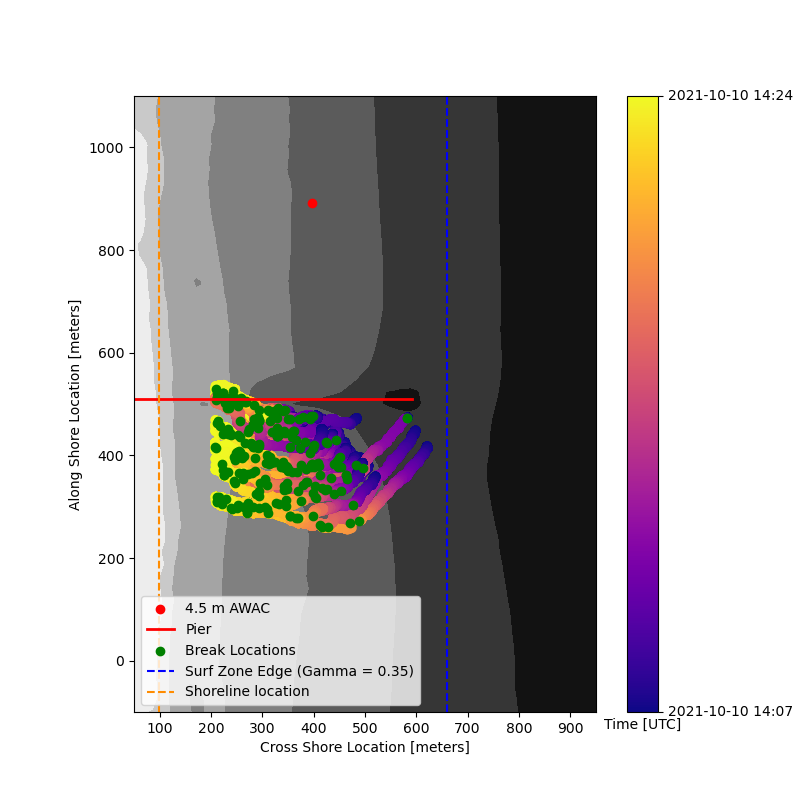

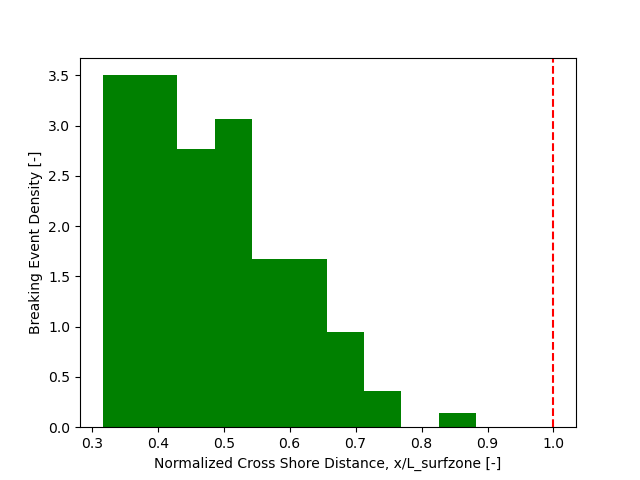

In [37]:
ax = mission_tools.plot_mission_tracks(mission_dataset, bathy_file)
ax.scatter(xFRF_break_locs, yFRF_break_locs, color='g', label='Break Locations')
ax.axvline(mission_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax.axvline(mission_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.legend()

fig, ax = plt.subplots()
ax.hist(xFRF_break_locs/mission_xs_gamma_location, bins=10, density=True, color='green')
ax.axvline(1, label='Surf Zone Edge', color='r', linestyle='dashed')
ax.set_xlabel('Normalized Cross Shore Distance, x/L_surfzone [-]')
ax.set_ylabel('Breaking Event Density [-]')

In [38]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')

xFRF_break_locs = []
yFRF_break_locs = []

xFRF_break_locs_norm = []

gamma = 0.35
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
waterlevel_file = '../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
waterlevel_dataset = nc.Dataset(waterlevel_file)
waterlevel = waterlevel_dataset['waterLevel'][:]
waterlevel_time = waterlevel_dataset['time'][:]

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    for microswift_num in range(mission_dataset['acceleration_z_body'].shape[0]):
        a_z_test = mission_dataset['acceleration_z_body'][microswift_num,:]
        xFRF_test = mission_dataset['xFRF'][microswift_num,:]
        yFRF_test = mission_dataset['yFRF'][microswift_num,:]
        mission_time = np.median(mission_dataset['time'][:])
        a_z_test_demean = a_z_test - np.nanmean(a_z_test)
        time_seconds = np.arange(a_z_test.size)/12

        # reshape time series into 5 second windows and compute variance
        window_size = 60 # 5 seconds at 12 Hz
        a_z_test_reshape = np.reshape(a_z_test_demean[:(a_z_test_demean.size//window_size * window_size)],
                                    (a_z_test_demean.size//window_size, window_size))
        time_seconds_reshape = np.reshape(time_seconds[:(time_seconds.size//window_size * window_size)],
                                        (time_seconds.size//window_size, window_size))
        xFRF_reshape = np.reshape(xFRF_test[:(xFRF_test.size//window_size * window_size)],
                                        (xFRF_test.size//window_size, window_size))
        yFRF_reshape = np.reshape(yFRF_test[:(yFRF_test.size//window_size * window_size)],
                                        (yFRF_test.size//window_size, window_size))
        a_z_test_window_var = np.nanvar(a_z_test_reshape, axis=1)
        time_seconds_window = np.nanmean(time_seconds_reshape, axis=1)
        xFRF_window = np.nanmean(xFRF_reshape, axis=1)
        yFRF_window = np.nanmean(yFRF_reshape, axis=1)
        total_varaince = np.nanvar(a_z_test_demean)

        # Find Indices where the variance spikes 
        above_thresh_inds = np.where(a_z_test_window_var > 2.5*total_varaince)
        
        # add x and y break locations
        xFRF_break_locs.append(xFRF_window[above_thresh_inds].flatten())
        yFRF_break_locs.append(yFRF_window[above_thresh_inds].flatten())

        # Compute depth that waves should be breaking in 
        mission_hs = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)
        mission_break_depth = mission_hs / gamma
        mission_xs_gamma_location = np.interp(-mission_break_depth, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))

        # Normalize the cross shore positions by the edge of surfzone estimate
        xFRF_break_locs_norm.append(xFRF_window[above_thresh_inds].flatten()/mission_xs_gamma_location)

xFRF_break_locs = np.ma.concatenate(xFRF_break_locs).flatten()
xFRF_break_locs_norm = np.ma.concatenate(xFRF_break_locs_norm).flatten()
yFRF_break_locs = np.ma.concatenate(yFRF_break_locs).flatten()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/543900671.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice.
  a_z_test_window_var = np.nanvar(a_z_test_reshape, axis=1)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/543900671.py:42: RuntimeWarning: Mean of empty slice
  xFRF_window = np.nanmean(xFRF_reshape, axis=1)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_19441/543900671.py:43: RuntimeWarning: Mean of empty slice
  yFRF_window = np.nanmean(yFRF_reshape, axis=1)


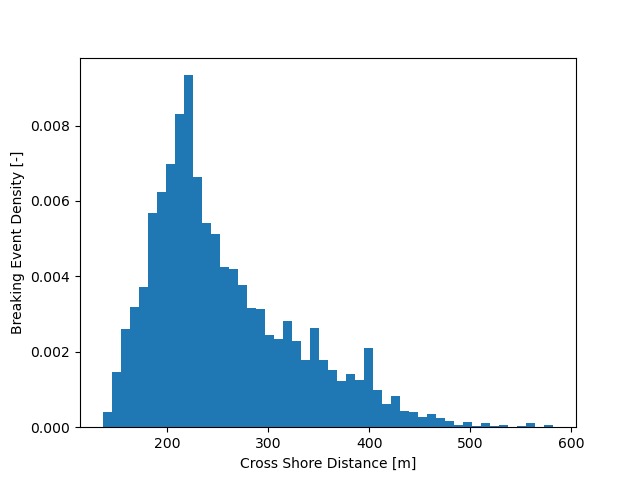

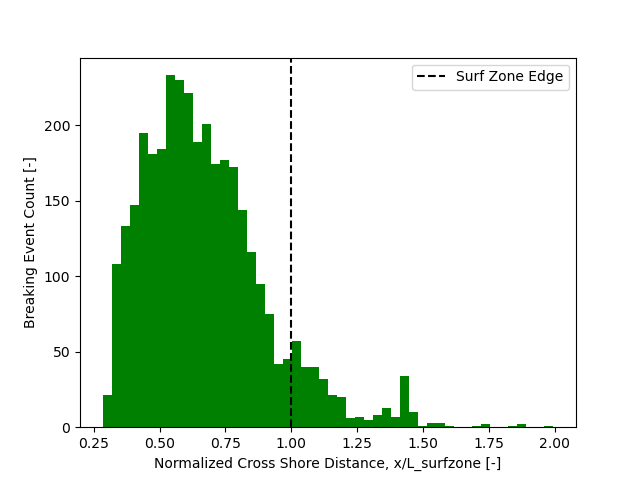

In [39]:
fig, ax = plt.subplots()
ax.hist(xFRF_break_locs, bins=50, density=True)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Breaking Event Density [-]')

fig, ax = plt.subplots()
ax.hist(xFRF_break_locs_norm, bins=50, density=False, color='green')
ax.axvline(1, label='Surf Zone Edge', color='k', linestyle='dashed')
ax.set_xlabel('Normalized Cross Shore Distance, x/L_surfzone [-]')
ax.set_ylabel('Breaking Event Count [-]')
ax.legend()

In [40]:
xFRF_break_locs_norm.size

3419